# Convolutional Neural Nets

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/tf/03-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

## Introduction

Objects in an image can be spatially perturbed slightly without changing its meaning. Features that exist locally seem to generalize better across multiple instances compared to larger ones. Hence, a local feature detector should be useful for tasks such as classification or object detection. It is not as useful for tasks that require composing multiple parts of images (e.g. pose detection). This is somewhat implemented by **convolutional layers** which operates somewhat like a fully-connected layers but with shared dependencies on the inputs. This reduces computation by orders and allows processing of images which is difficult for MLPs. Moreover, convolutional layers can be stacked to obtain heirarchical features with depth. 

<br>

In [1]:
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_inline import backend_inline

import torch
import torchvision
import torch.nn as nn

DATASET_DIR = Path("./data/").resolve()
warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')
matplotlib.rcParams["image.interpolation"] = "nearest"

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(torch.__version__)
print(torch.backends.mps.is_built())
device = torch.device('mps')

2.0.0
True


## Convolution operation

Suppose we want to classify cat images using a linear model. Flattening the image into a vector discards important spatial information, i.e. a network with a preprocessing layer that permutes the input achieves the same result. Also, the resulting vector is too long. 
For example, the two pixels indicated on the left image below do not need to be mixed to figure out that the image is a cat. On the other hand, three nearby pixels on the right image can form a linear combination that can be useful for determining cat-like features. This results in a very sparse banded weight matrix ({numref}`toeplitz`).

```{figure} ../../img/cat-conv.png
---
width: 40em
---
Nearby pixels constitute meaningful features of images.
```

Let $\boldsymbol{\mathsf X}$ be the input image and $\boldsymbol{\mathsf{S}}$ be the output feature map. Suppose $\mathsf{n}^2 = |\boldsymbol{\mathsf X}|$ and $\mathsf{m}^2 = |\boldsymbol{\mathsf{S}}|.$ Having a banded weight matrix reduces the nonzero entries of the weight matrix from $\mathcal{O}(\mathsf{m}^2 \mathsf{n}^2)$ to $\mathcal{O}(\mathsf{m}^2{\mathsf k}^2)$ where a local region of $\mathsf{k} \times \mathsf{k}$ pixels in the input are mixed. It makes sense to further constrain the weights in the local region to be equal througout the image since we want to capture translationally invariant features. This further reduces the number of weights to $\mathsf{k}^2.$ The resulting linear operation is called a **convolution** written in two spatial dimensions as:

$$
\boldsymbol{\mathsf{S}} = (\boldsymbol{\mathsf X} \circledast \boldsymbol{\mathsf{K}})_{ij} = \sum_{x = 0}^{{\mathsf k}-1} \sum_{y=0}^{{\mathsf k}-1} {\boldsymbol{\mathsf X}}_{i + x, j + y} \, {\boldsymbol{\mathsf{K}}}_{xy}.
$$

Observe that spatial ordering of the pixels in the input $\boldsymbol{\mathsf X}$ is somewhat preserved in the output $\boldsymbol{\mathsf{S}}.$ This is nice since we want spatial information and orientation across a stack of convolution operations to be preserved in the final output.

```{margin}
Figure source:<br>
[`deepimaging.github.io`](https://deepimaging.github.io/lectures/lecture_9_intro_to_CNN's.pdf)
```
```{figure} ../../img/conv-cat-99.png
---
width: 30em
name: toeplitz
---
Banded Toeplitz matrix for classifying cat images. The horizontal vectors contain the same pixel values. The picture here is a bit inaccurate. There should be multiple bands if the kernel is 2-dimensional with size `k × k`. See this [SO answer](https://stackoverflow.com/a/44039201/1091950).
```

### Convolution layers

Convolution layers extend the convolution operation to handle images with multiple **channels** (e.g. RGB images have 3 channels). Similarly, we want to output feature maps with channels as this adds a further semantic dimension. The layer learns three-dimensional kernels $\boldsymbol{\mathsf{K}}_{kc}$ for each input-output channel pair. Note that features across input channels are blended by the kernel. The layer can be thought to learn one feature detector for each output channel:

$$
\begin{aligned}
{\bar{\boldsymbol{\mathsf X}}}_{kij}
&= {\boldsymbol{\mathsf u}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1} ({\boldsymbol{\mathsf X}}_{[c,\,:,\, :]} \circledast {\boldsymbol{\mathsf K}}_{[k,\,{c},\, :,\,:]})_{ij} \\
&= {\boldsymbol{\mathsf u}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1}\sum_{x = 0}^{{\mathsf k}-1} \sum_{y=0}^{{\mathsf k}-1} {\boldsymbol{\mathsf X}}_{i + x,\, j + y,\, c} \, {\boldsymbol{\mathsf K}}_{kcxy} \\
\end{aligned}
$$

for $k = 0, \ldots, {\mathsf c}_\text{out}-1$. The input and output tensors $\boldsymbol{\mathsf{X}}$ and $\bar{\boldsymbol{\mathsf{X}}}$ have the same dimensionality and semantic structure which makes sense since we want to stack convolutional layers as modules, and the kernel $\boldsymbol{\mathsf{K}}$ has shape $({\mathsf c}_\text{out}, {\mathsf c}_\text{in}, {\mathsf k}, {\mathsf k}).$ The resulting feature maps inherit the spatial ordering in its inputs along its spatial dimensions. Note that convolution requires the same set of operations as a linear layer it just applies weights to different parts of the image.

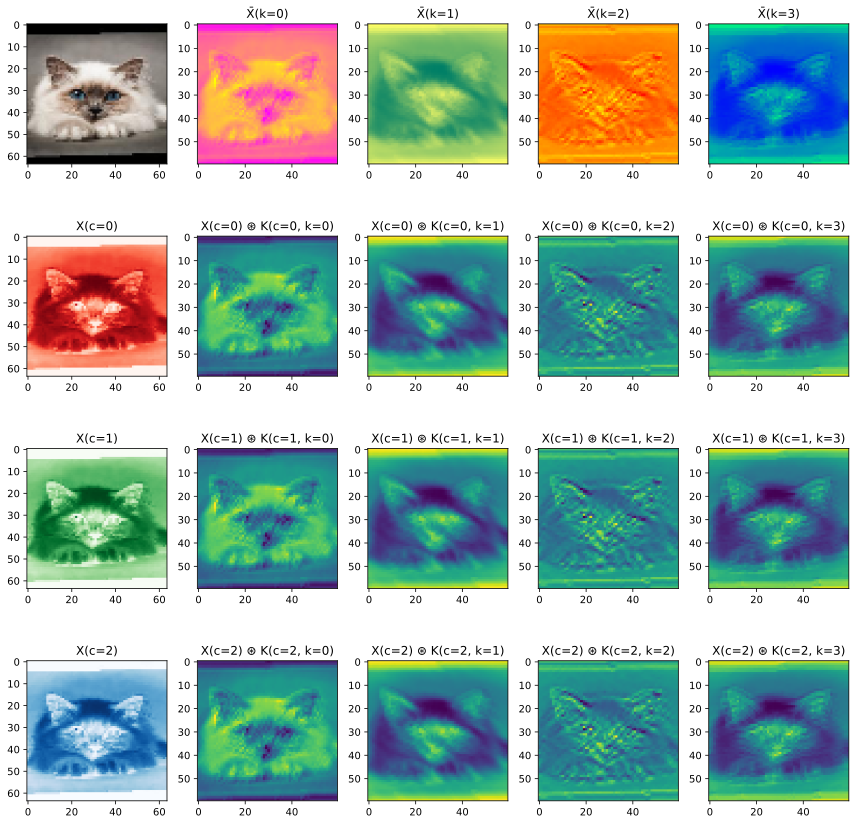

In [2]:
from torchvision.io import read_image
import torchvision.transforms.functional as fn


def conv_components(*, X, conv, act):
    """Components of a convolution of an RGB image with 4 output channels."""
    
    cmaps = ['Reds', 'Greens', 'Blues']
    cmaps_out = ['spring', 'summer', 'autumn', 'winter']

    # Get kernel weights
    K, u = conv.weight, conv.bias

    c_in  = X.shape[1]
    c_out = K.shape[0]

    # Iterate over in channels
    fig, ax = plt.subplots(c_in+1, c_out+1, figsize=(12, 12))
    ax[0, 0].imshow(X[0].permute(1, 2, 0))
    for c in range(c_in):
        ax[c+1, 0].set_title(f'X(c={c})')
        ax[c+1, 0].imshow(X[0, c, :, :], cmap=cmaps[c])

    # Iterate over kernel filters
    outs = {}
    for k in range(c_out):
        conv_k = nn.Conv2d(out_channels=1, in_channels=3, kernel_size=conv.kernel_size)
        T, v = conv_k.weight, conv_k.bias
        T.data = conv.weight[k:k+1, :, :, :]
        v.data = conv.bias[[k]]
        for c in range(c_in):
            outs[(c, k)] = conv_k(X)[0, 0, :, :]
            ax[c+1, k+1].imshow(outs[(c, k)].detach().numpy()) 
            ax[c+1, k+1].set_title(f"X(c={c}) ⊛ K(c={c}, k={k})")

    # Sum convolutions for each input channel
    for k in range(c_out):
        ax[0, k+1].imshow(sum([outs[(c, k)] for c in range(c_in)]).detach().numpy(), cmaps_out[k])
        ax[0, k+1].set_title(r"$\bar{\mathrm{X}}$" + f'(k={k})')

    fig.tight_layout()
    # return outs


cat = DATASET_DIR / "cat2dog/cat2dog/testA/14.jpg"
X = read_image(str(cat)).unsqueeze(0)
X = fn.resize(X, size=(64, 64)) / 255.
torch_conv = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5)
conv_components(X=X, conv=torch_conv, act='');

**Figure.** Here we can see that the channels of convolutional layers are analogous to units of dense layers. Each kernel in entries `i,j > 0` combines column-wise with the inputs to compute `X(c=i) ⊛ K(c=i, k=j)`. The sum of these terms form the output map `X̅(k=j)` above. 

**Remark.** This looks like matrix multiplication which dense layers implement but with convolutions between 2-dimensional matrices instead of products between scalar nodes. This means CNNs also perform combinatorial mixing of heirarchical features with depth.

### Formula from scratch

The idea behind the convolution layer is that instead of learning a weight for each pixel input, we learn weights for a small feature detector that we slide across the image. Here we implement the formula above for convolution and check whether it is consistent with PyTorch `Conv2d`. This layer expects input images to have shape `(B, H, W, c)` for a batch input of size `B` of `H × W` images with `c` channels.

Input shape:  torch.Size([1, 3, 64, 64])
Output shape: (1, 4, 60, 60)
Kernel shape: torch.Size([4, 3, 5, 5])
Bias shape:   torch.Size([4])
MAE (w/ pytorch) = 5.682434574636217e-08

Output components (from scratch):


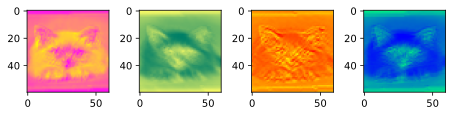

In [3]:
@np.vectorize
def np_relu(x):
    return max(0.0, x)

def scratch_conv(X, K, u):
    """Implementing a 2D convolutional layer from scratch."""

    h, w = K.shape[2:]
    B, c_in, H0, W0 = X.shape
    H1 = H0 - h + 1
    W1 = W0 - w + 1
    c_out = K.shape[0]

    S = np.zeros(shape=(B, c_out, H1, W1))
    for b in range(S.shape[0]):
        for k in range(S.shape[1]):
            for i in range(S.shape[2]):
                for j in range(S.shape[3]):
                    # Perform 3D convolution (c_in, h, w) for each out channel
                    S[b, k, i, j] = u[k] + (K[k, :, :, :] * X[b, :, i:i+h, j:j+w]).sum()
    return S


X = read_image(str(cat)).unsqueeze(0)
X = fn.resize(X, size=(64, 64)) / 255.
K = torch_conv.weight.data
u = torch_conv.bias.data
S = scratch_conv(X, K, u)
cmaps_out = ['spring', 'summer', 'autumn', 'winter']

print("Input shape: ", X.shape)   # (B, H_in,  W_in,  c_in)
print("Output shape:", S.shape)   # (B, H_out, W_out, c_out)
print("Kernel shape:", K.shape)   # (h, w, c_in, c_out)
print("Bias shape:  ", u.shape)   # (c_out,)

# Check if above formula agrees with PyTorch implementation
print("MAE (w/ pytorch) =", (torch.tensor(S) - torch_conv(X)).abs().mean().item())

# Plotting the images obtained using the above formula
print("\nOutput components (from scratch):")
fig, ax = plt.subplots(1, 4)
for k in range(4):
    ax[k].imshow(S[0, k, :, :], cmaps_out[k])
fig.tight_layout()

### Padding and stride

The above definition of convolution can be modified to include a parameter called the **stride** that controls the step size of the kernel when it slides over the input image. A larger stride along with a large kernel size can be useful if objects are large relative to the dimension of the image. Note that stride also significantly reduces computation. Strided convolutions have been used as an alternative way to downsample an image {cite}`allconv`.

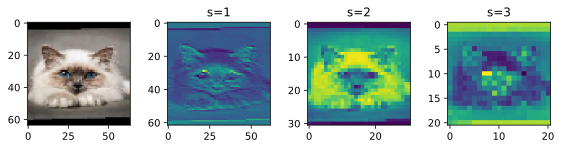

In [4]:
conv = lambda s: nn.Conv2d(in_channels=3, out_channels=3, stride=s, kernel_size=3)
fig, ax = plt.subplots(1, 4, figsize=(8, 2))

ax[0].imshow(X[0].permute(1, 2, 0))
ax[1].imshow(conv(1)(X)[0, 0].detach().numpy()); ax[1].set_title("s=1")
ax[2].imshow(conv(2)(X)[0, 0].detach().numpy()); ax[2].set_title("s=2")
ax[3].imshow(conv(3)(X)[0, 0].detach().numpy()); ax[3].set_title("s=3")
fig.tight_layout();

Notice that central pixels are overrepresented in the output since the kernels have to be fitted within the input image. This results in information loss on the boundaries of the input as we stack more convolutional layers. A more straightforward issue is that convolutions decrease the spatial dimension of its input which limits network depth. This can be easily fixed by **zero padding** the boundaries of layer inputs which allows each kernel to be placed over the boundaries:

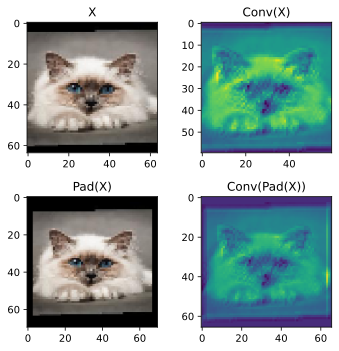

In [5]:
pad  = nn.ZeroPad2d(padding=3)
conv = torch_conv

fig, ax = plt.subplots(2, 2, figsize=(5, 5))
ax[1, 0].imshow(pad(X)[0].permute(1, 2, 0).detach());   ax[1, 0].set_title("Pad(X)")
ax[1, 1].imshow(conv(pad(X))[0, 0].detach());           ax[1, 1].set_title("Conv(Pad(X))")
ax[0, 0].imshow(X[0].permute(1, 2, 0).detach());        ax[0, 0].set_title("X")
ax[0, 1].imshow(conv(X)[0, 0].detach());                ax[0, 1].set_title("Conv(X)")
fig.tight_layout();

**Output size.** Note that padding and stride has a direct effect on spatial dimensions of the output feature maps. An input with width `w` and equal padding `p`, and kernel size `k` with stride `s` has an output with width `⌊(w + 2p - k)/s + 1⌋`. Note that we have to carefully choose stride and padding values so that the kernel can be placed evenly in the image so that no input pixel is dropped. 

* For $\mathsf{s} = 1,$ kernel size should be odd so that it covers the entire input in a symmetric manner. A common choice is `p = (k - 1)/2` which results in same sized outputs (i.e. **same convolution**). 

+++

* For $\mathsf{s} > 1,$ the best practice is to choose a kernel size and the smallest `p` such that `s` divides `w + 2p - k` so the entire input image is symmetrically covered by the kernel.

### Receptive field and pooling

The **receptive field** of a unit of a hidden layer consists of all units from previous layers that influences its value during forward pass. In particular, units for each class in the softmax layer should have a receptive field that includes the entire input. Otherwise, some parts of the input will not affect the prediction of the model for that class. These regions can be thought of as dead pixels or blind spots of the model for that class. 

```{margin}
Fig 14.2 in {cite}`geron2019hands-on`
```
```{figure} ../../img/receptive_field.png
---
width: 28em
---
Receptive field of a pixel in a convolutional network.
```

Receptive field can be exponentially increased by **pooling** or **downsampling** characterized by aggregating input pixels to make the dimensions of the image smaller for the next layer. This decreases computation and can be thought of as eliminates redundant or extraneous details making the model more robust to noise.

```{margin}
Figure from: <br>
[`cs231n/conv-nets`](https://cs231n.github.io/convolutional-networks/)
```

```{figure} ../../img/pooling-cs231n.png
---
width: 300px

---

Pooling layer downsamples the volume spatially independently in each channel. The input tensor of size 224 × 224 × 64 is pooled with filter size 2 and stride 2 into output volume of size 112 × 112 × 64.
```

CNNs use **pooling layers** which downsamples an input by moving across it like convolutional layers set stride, padding, and kernel size but are nonparametric. Pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure. 

Pooling layers include max pooling, average pooling, etc. Max pooling makes the network tolerant to small noise or fine-grained details in the input at the cost of some information loss. It can also be interpreted as a form of competition between neurons since the gradient only flows through the activated neuron.

In [6]:
X = torch.tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, None, :, :].float()

pool = nn.MaxPool2d(kernel_size=2, stride=2)

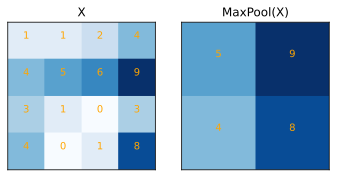

In [7]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
ax[0].set_title("X")
ax[0].imshow(X.numpy()[0, 0, :, :], cmap='Blues', vmin=0)
ax[0].set_xticks([])
ax[0].set_yticks([])
for i in range(4):
    for j in range(4):
        ax[0].text(j, i, int(X[0, 0, i, j].numpy()), ha="center", va="bottom", color='orange')

ax[1].set_title("MaxPool(X)")
ax[1].imshow(pool(X)[0].detach().permute(1, 2, 0), cmap='Blues', vmin=0)
ax[1].set_xticks([])
ax[1].set_yticks([])
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, int(pool(X)[0, 0, i, j].numpy()), ha="center", va="bottom", color='orange')

fig.tight_layout()

Commonly used settings are `k = 2, s = 2` where the pooling regions are do not overlap, and the more aggressive overlapping pooling `k = 3, s = 2`. Using larger kernel sizes can be too aggressive resulting in loss of discriminative information. This can be observed below where the power line is removed.

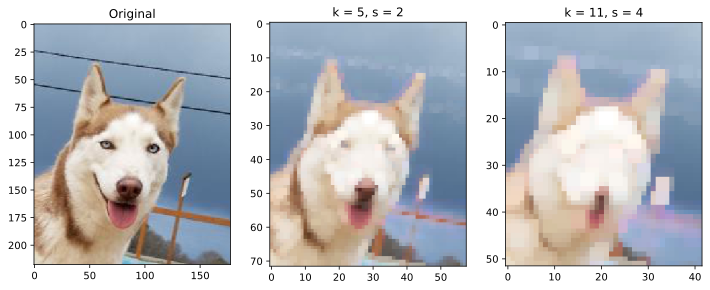

In [8]:
dog = DATASET_DIR / "cat2dog/cat2dog/trainB/75.jpg"
image = read_image(str(dog)).unsqueeze(0) / 255.

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image[0, :, :, :].permute(1, 2, 0))
ax[0].set_title("Original")
ax[1].imshow(nn.MaxPool2d(kernel_size=5, stride=3)(image)[0, :, :, :].permute(1, 2, 0))
ax[1].set_title("k = 5, s = 2")
ax[2].imshow(nn.MaxPool2d(kernel_size=11, stride=4)(image)[0, :, :, :].permute(1, 2, 0))
ax[2].set_title("k = 11, s = 4");

## Implementing a CNN

CNNs consist of stacking `[Conv→ReLU→Pool]` blocks. This is typical in the design of network architectures: using **blocks** composed of layers that together forms a basic functional unit. Here the spatial dimensions are downsampled while increasing the number of output channels so that network capacity is not diminished. The resulting feature map is small enough to be passed as an input vector to the dense classification subnetwork.

```{margin}
Figure source: <br>
[`github.com/rasbt/`](https://github.com/rasbt/machine-learning-book/blob/main/ch14/figures/14_12.png)
```
```{figure} ../../img/convnet.png
---
---
Visualizing the architecture of our CNN network.

```

Here we use a width of 512 in the last dense layer instead of 1024 indicated in the figure. This significantly reduces the number of parameters of the model. To aid with activation and gradient stability, we add BatchNorm {cite}`batchnorm` layers after each convolution.

In [9]:
from torchsummary import summary

mnist_model = lambda: nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(32),
    
    nn.Conv2d(32, 64, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(64),

    nn.Flatten(),
    nn.Linear(64*7*7, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

summary(mnist_model(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
            Conv2d-5           [-1, 64, 14, 14]          51,264
              ReLU-6           [-1, 64, 14, 14]               0
         MaxPool2d-7             [-1, 64, 7, 7]               0
       BatchNorm2d-8             [-1, 64, 7, 7]             128
           Flatten-9                 [-1, 3136]               0
           Linear-10                  [-1, 512]       1,606,144
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 1,663,562
Trainable param

**Remarks.** For convolutional layers, width corresponds to the number of channels of the output feature maps. Increasing the width directly increases the capacity of the network, i.e. learning more feature detectors. Feature detectors are stacked resulting in feature detectors acting on earlier detected features. This allows using less weights by combining heirarchical feature representations. The tradeoff is that these representations are generally more difficult to learn properly. This motivates the use of normalization layers in between blocks.

### Training

Setting up MNIST data loaders:

In [10]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x/255.)
])

mnist_all = MNIST(
    root=DATASET_DIR,
    download=False,
    transform=transform
)

mnist_train, mnist_valid = random_split(
    mnist_all, [55000, 5000], 
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

dl_train = DataLoader(mnist_train, batch_size=64)
dl_valid = DataLoader(mnist_valid, batch_size=64)

Setting up training:

In [11]:
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F

model = mnist_model().to(device)
loss_fn = lambda logits, y: F.cross_entropy(logits, y)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
for epoch in tqdm(range(5)):
    for x, y in dl_train:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        losses.append(loss.item())

  0%|          | 0/5 [00:00<?, ?it/s]

Training loss:

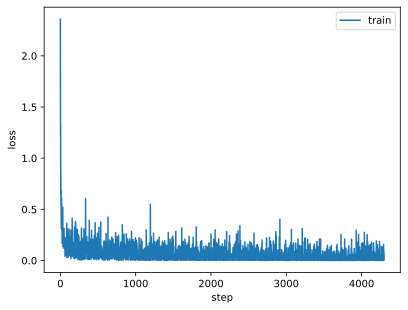

In [12]:
plt.xlabel("step")
plt.ylabel("loss")
plt.plot(losses, label="train")
plt.legend();

**Remark.** This model even if shallow does not train with BN removed.

In [13]:
min(losses)

2.2356467525241897e-05

### Feature maps

Let us visualize how an input is transformed into feature maps as it passes through the network during training. Note that the filters shown are truncated to 5 each layer for lack of space.

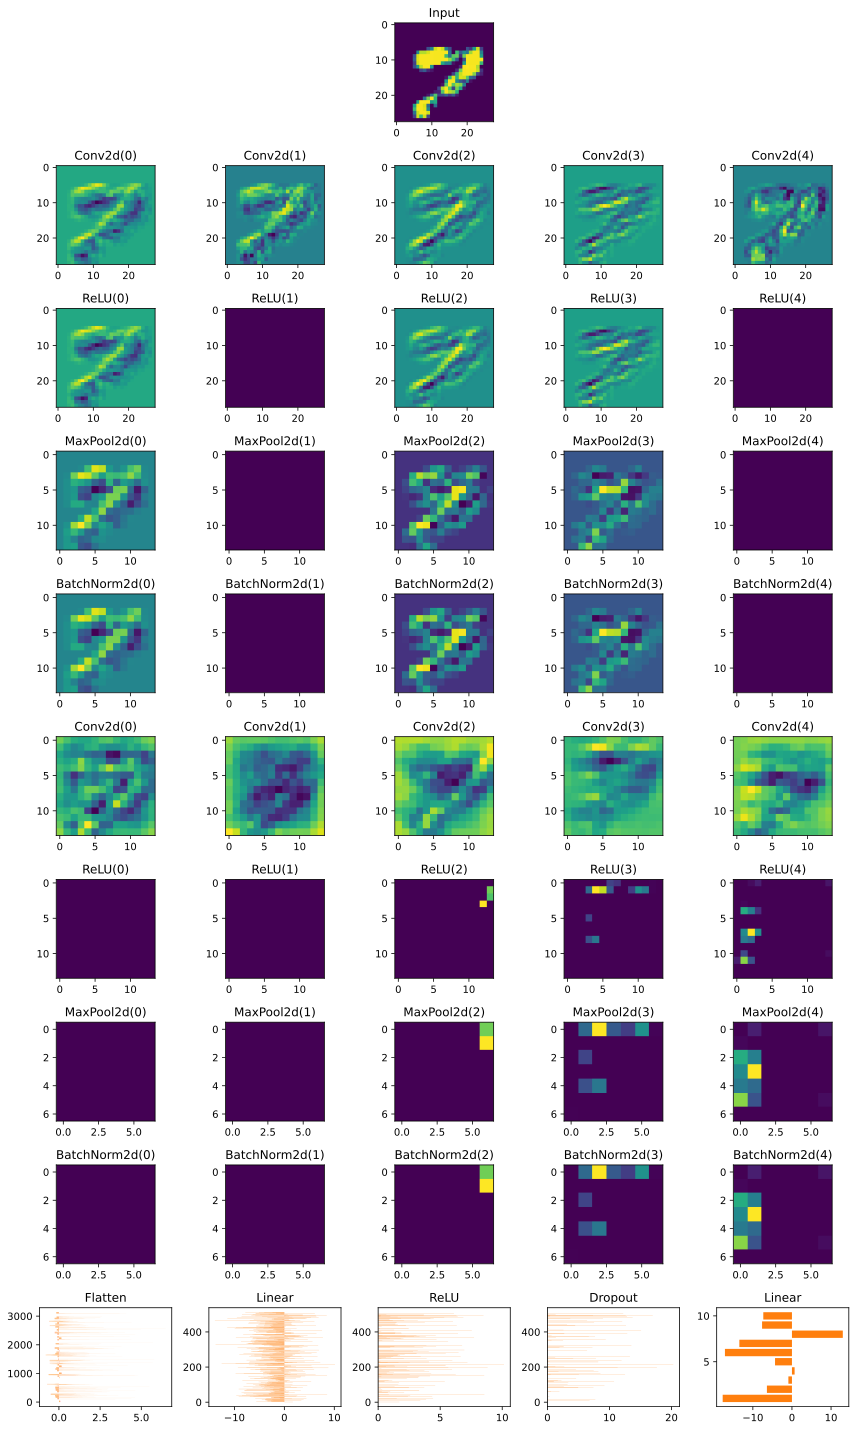

In [14]:
x, y = next(iter(dl_valid))
x = x[5:6, :].to(device)

fig, ax = plt.subplots(10, 5, figsize=(12, 20))
ax[0, 2].set_title("Input")
ax[0, 2].imshow(x[0, 0].cpu().detach().numpy())
ax[0, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[0, 3].set_axis_off()
ax[0, 4].set_axis_off()

for k in range(8):
    x = model[k](x)
    for j in range(5):
        ax[k+1, j].set_title(type(model[k]).__name__ + f"({j})")
        ax[k+1, j].imshow(x[0, j].cpu().detach().numpy())

for l in range(5):
    x = model[8+l](x)
    ax[9, l].set_title(type(model[8+l]).__name__)
    ax[9, l].barh(range(1, x.shape[1]+1), x[0].cpu().detach().numpy(), color="C1")

fig.tight_layout()

**Figure.** Each input feature map of a convolutional layer is used to create each output feature map. Max-pooling and ReLU on the other hand just passes feature maps downward. BatchNorm layers have dependencies along the batch dimension that is suppressed in this visual.

Model predicts the correct label 7 and also rightly think it looks like a 3:

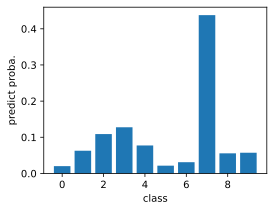

In [15]:
import torch.nn.functional as F
temp = 10.0
plt.figure(figsize=(4, 3))
plt.bar(range(10), F.softmax(x/temp, dim=1).detach().cpu()[0])
plt.xlabel("class")
plt.ylabel("predict proba.");

## Data augmentation

FashionMNIST is not too rich to represent variations in real-world datasets. For example, the images are nicely centered and those belonging to the same class have similar scales. In this section, we will create a CNN for classifying smiling faces. We use a small subset consisting of 16,000 faces in [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) {cite}`celeb_a`. 

### Transforms

This is relatively small for this task, i.e. we will not get good results by directly training the same network architecture for this dataset. To make the model generalize, we have to use **data augmentation**. This technique incorporates transformed or perturbed versions of the original images into the dataset.

In [16]:
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

These transforms do not change whether a face is smiling or not. Here we randomly crop and flip versions of the original images. Cropping has the effect of perturbing the position of a smile by a small amount. Flipping makes sense since the face has mirror symmetry. Augmentation is built into data loaders with stochastic transforms:

In [17]:
from torchvision.datasets import CelebA
from torch.utils.data import Subset

get_smile = lambda attr: attr[31].item() # hacks (see list_attr_celeba.txt)
celeba_train = CelebA(DATASET_DIR, download=True, split="train", target_type="attr", transform=transform_train, target_transform=get_smile)
celeba_valid = CelebA(DATASET_DIR, download=True, split="valid", target_type="attr", transform=transform,       target_transform=get_smile)
celeba_test  = CelebA(DATASET_DIR, download=True, split="test",  target_type="attr", transform=transform,       target_transform=get_smile)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [18]:
# https://www.youtube.com/watch?v=d6H-HEpnlk8
for dt in [celeba_train, celeba_valid, celeba_test]:
    s = 0
    for img, tgt in dt:
        s += tgt
    print(f"{s / len(dt):.3f}")

0.480
0.483
0.500


Simulating images across epochs:

In [19]:
simul_train = DataLoader(Subset(celeba_train, torch.arange(3)), batch_size=1, shuffle=True)
simul_valid = DataLoader(Subset(celeba_valid, torch.arange(1)), batch_size=1, shuffle=False)
simul_test  = DataLoader(Subset(celeba_test,  torch.arange(1)), batch_size=1, shuffle=False)

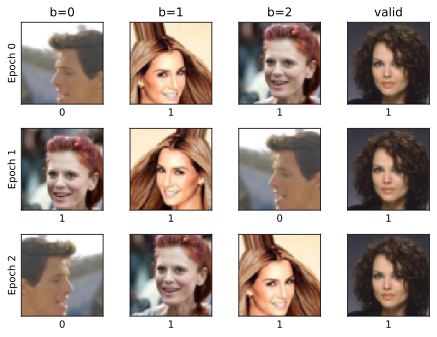

In [20]:
fig, ax = plt.subplots(3, 4)
for e in range(3):
    for i, (img, tgt) in enumerate(simul_train):
        if i == 0:
            ax[e, i].set_ylabel(f"Epoch {e}")
        ax[e, i].imshow(img[0].permute(1, 2, 0).detach())
        ax[e, i].set_xlabel(tgt[0].item())
        ax[e, i].set_xticks([])
        ax[e, i].set_yticks([])
        ax[0, i].set_title(f"b={i}")

    img_val, tgt_val = next(iter(simul_valid))
    ax[e, 3].set_xlabel(tgt_val[0].item())
    ax[e, 3].imshow(img_val[0].permute(1, 2, 0).detach())
    ax[e, 3].set_xticks([])
    ax[e, 3].set_yticks([])

ax[0, 3].set_title('valid')
fig.tight_layout()

**Figure.** Inputs are stochastically transformed at each epoch. Note that the labels are not affected (both at the recognition and implementation level). The test and validation sets have fixed transformations implementing sort of the expectation of the random transformations.

### CNN + GAP

Our network architecture is similar to the MNIST network above. But here we use **global average-pooling** (GAP) which averages all pixels in the 8 × 8 feature map into a single pixel. This makes the model more robust to small spatial translations in the input. Note that this preserves the channel structure resulting in reduced output vector of length 256. This vector is then passed to a dense layer to perform classification.

In [21]:
def celeba_model(): 
    model = nn.Sequential()

    model.add_module('conv1', nn.Conv2d(3, 32, kernel_size=5, padding=3))
    model.add_module('relu1', nn.ReLU())
    model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
    model.add_module('norm1', nn.BatchNorm2d(32))

    model.add_module('conv2', nn.Conv2d(32, 64, kernel_size=3, padding=1))
    model.add_module('relu2', nn.ReLU())
    model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
    model.add_module('norm2', nn.BatchNorm2d(64))

    model.add_module('conv3', nn.Conv2d(64, 128, kernel_size=3, padding=1))
    model.add_module('relu3', nn.ReLU())
    model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
    model.add_module('norm3', nn.BatchNorm2d(128))

    model.add_module('conv4', nn.Conv2d(128, 256, kernel_size=3, padding=1))
    model.add_module('relu4', nn.ReLU())
    model.add_module('pool4', nn.AvgPool2d(kernel_size=8))

    model.add_module('flatten', nn.Flatten())
    model.add_module('fc', nn.Linear(256, 2))

    return model


summary(celeba_model(), input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 66, 66]           2,432
              ReLU-2           [-1, 32, 66, 66]               0
         MaxPool2d-3           [-1, 32, 33, 33]               0
       BatchNorm2d-4           [-1, 32, 33, 33]              64
            Conv2d-5           [-1, 64, 33, 33]          18,496
              ReLU-6           [-1, 64, 33, 33]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9          [-1, 128, 16, 16]          73,856
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

### Training and results

Combining the data loaders into one module:

In [22]:
import torch.nn.functional as F
from torchmetrics import Accuracy

class CelebADataModule:
    def __init__(self, batch_size):
        super().__init__()

        self.train = DataLoader(
            Subset(celeba_train, torch.arange(16000)),
            batch_size=batch_size, 
            shuffle=True
        )

        self.valid = DataLoader(
            Subset(celeba_valid, torch.arange(1000)), 
            batch_size=batch_size, 
            shuffle=False
        )
    
        self.test = DataLoader(
            Subset(celeba_test, torch.arange(1000)), 
            batch_size=batch_size, 
            shuffle=False
        )

Here we define a trainer that clearly separates concern during model training. We use the [torchmetrics](https://torchmetrics.readthedocs.io/en/stable/) library to clean up metric computation. These are stateful which explains the `.update` and `.compute` methods. Note that the validation step uses sum reduction since the results are accumulated per instance, and collected at the end of one validation epoch (i.e. one pass through the validation dataset). On the other hand train metrics are accumulated at each step and the computed value is the average of all steps so far.

In [23]:
import torchmetrics
import contextlib

class Trainer:
    def __init__(self, model, optim, loss_fn, device=device, verbose=True):
        self.model = model.to(device)
        self.optim = optim
        self.device = device
        self.loss_fn = loss_fn
        self.train_log = {'loss': [], 'accs': []}
        self.valid_log = {'loss': [], 'accs': []}
        self.verbose = verbose
    
    def __call__(self, x):
        return self.model(x.to(self.device))

    def forward(self, batch):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        return self.model(x), y

    def train_step(self, batch):
        preds, y = self.forward(batch)
        accs = (preds.argmax(dim=1) == y).float().mean()
        loss = self.loss_fn(preds, y)
        loss.backward()
        self.optim.step()
        self.optim.zero_grad()
        return {'loss': loss, 'accs': accs}

    @torch.no_grad()
    def valid_step(self, batch):
        preds, y = self.forward(batch)
        accs = (preds.argmax(dim=1) == y).float().sum()
        loss = self.loss_fn(preds, y, reduction='sum')
        return {'loss': loss, 'accs': accs}
    
    def run(self, epochs, data_module):
        self.train_log['loss'].clear()
        self.train_log['accs'].clear()
        self.valid_log['loss'].clear()
        self.valid_log['accs'].clear()

        loss_metric = torchmetrics.MeanMetric().to(device)
        accs_metric = torchmetrics.MeanMetric().to(device)

        for e in tqdm(range(epochs)):
            for batch in data_module.train:
                output = self.train_step(batch)

                # logs @ train step
                loss_metric.update(output['loss'])
                accs_metric.update(output['accs'])
                self.train_log['loss'].append(loss_metric.compute().item())
                self.train_log['accs'].append(accs_metric.compute().item())

            # logs @ epoch
            output = self.evaluate(data_module.valid)
            self.valid_log['loss'].append(output['loss'])
            self.valid_log['accs'].append(output['accs'])
            if self.verbose:
                print(f"[Epoch: {e+1:>0{int(len(str(epochs)))}d}/{epochs}]   loss: {self.train_log['loss'][-1]:.4f}    val_loss: {self.valid_log['loss'][-1]:.4f}    val_acc: {self.valid_log['accs'][-1]:.4f}")
    
    @contextlib.contextmanager
    def eval_context(self):
        self.model.eval()
        try:
            yield
        finally:
            self.model.train()

    def evaluate(self, data_loader):
        with self.eval_context():
            valid_loss = 0.0
            valid_accs = 0.0
            for batch in data_loader:
                output = self.valid_step(batch)
                valid_loss += output['loss'].item()
                valid_accs += output['accs'].item()

        return {
            'loss': valid_loss / len(data_loader.dataset),
            'accs': valid_accs / len(data_loader.dataset)
        }

    def predict(self, data_loader):
        with self.eval_context():
            preds = []
            for x in data_loader:
                with torch.no_grad():
                    x = x.to(device)
                    preds.append(self.model(x))

        return torch.cat(preds, dim=0)

The use of `eval_context` is there because layers like BN have different train and inference behavior. Note that models in PyTorch are in train mode by default. This context manager handles the state so that the model is in train mode after validation and prediction. Training the model using Adam {cite}`adam` with a learning rate of `0.001` and a batch size 32:

In [24]:
celeba_dm = CelebADataModule(batch_size=32)
model = celeba_model()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, optim, loss_fn=F.cross_entropy)
trainer.run(epochs=25, data_module=celeba_dm)

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 01/25]   loss: 0.6415    val_loss: 0.7481    val_acc: 0.5700
[Epoch: 02/25]   loss: 0.5372    val_loss: 0.4874    val_acc: 0.8070
[Epoch: 03/25]   loss: 0.4558    val_loss: 0.3541    val_acc: 0.8480
[Epoch: 04/25]   loss: 0.4085    val_loss: 0.2950    val_acc: 0.8720
[Epoch: 05/25]   loss: 0.3759    val_loss: 0.2589    val_acc: 0.8870
[Epoch: 06/25]   loss: 0.3517    val_loss: 0.2997    val_acc: 0.8610
[Epoch: 07/25]   loss: 0.3329    val_loss: 0.2259    val_acc: 0.9060
[Epoch: 08/25]   loss: 0.3177    val_loss: 0.2921    val_acc: 0.8750
[Epoch: 09/25]   loss: 0.3052    val_loss: 0.2617    val_acc: 0.8910
[Epoch: 10/25]   loss: 0.2947    val_loss: 0.2449    val_acc: 0.8940
[Epoch: 11/25]   loss: 0.2858    val_loss: 0.2313    val_acc: 0.9010
[Epoch: 12/25]   loss: 0.2780    val_loss: 0.2316    val_acc: 0.9060
[Epoch: 13/25]   loss: 0.2710    val_loss: 0.2723    val_acc: 0.8890
[Epoch: 14/25]   loss: 0.2647    val_loss: 0.2305    val_acc: 0.9010
[Epoch: 15/25]   loss: 0.2590    v

In [25]:
def plot_training_history(trainer):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    N = len(celeba_dm.train)
    B = len(trainer.valid_log['loss'])

    ax[0].plot(trainer.train_log['loss'], label='train')
    ax[1].plot(trainer.train_log['accs'], label='train')
    ax[0].plot(range(N, (B + 1) * N, N), trainer.valid_log['loss'], label='valid')
    ax[1].plot(range(N, (B + 1) * N, N), trainer.valid_log['accs'], label='valid')
    ax[0].set_xlabel('step')
    ax[0].set_ylabel('loss')
    ax[0].grid(linestyle='dashed', alpha=0.3)
    ax[0].legend()
    ax[1].set_xlabel('step')
    ax[1].set_ylabel('accuracy')
    ax[1].grid(linestyle='dashed', alpha=0.3)
    ax[1].legend()
    
    fig.tight_layout();

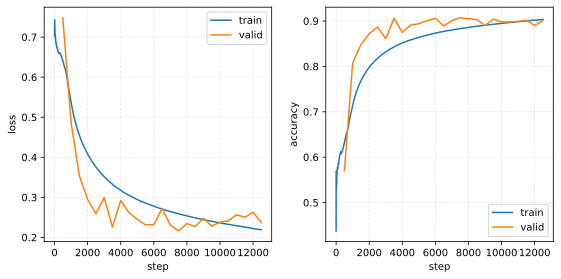

In [26]:
plot_training_history(trainer)

**Remark.** This trains pretty well due to BatchNorm. Also, if we turn off data augmentation the validation curves diverge and the model overfits on the train set very early in the training. Using augmentation prevents the model from memorizing the dataset and allows its large capacity to saturate on training data noise.

Trained model validation performance:

In [27]:
trainer.evaluate(celeba_dm.valid)

{'loss': 0.23673818850517273, 'accs': 0.901}

Testing if consistent with predict:

In [28]:
class InputDataLoader(DataLoader):
    def __init__(self, orig_data_loader):
        self.orig_data_loader = orig_data_loader

    def __iter__(self):
        for inputs, _ in self.orig_data_loader:
            yield inputs

Y = torch.cat([y.to(device) for x, y in celeba_dm.valid])
X = InputDataLoader(celeba_dm.valid)
preds = trainer.predict(X)
print(f"loss: {F.cross_entropy(preds, Y).item():.4f}")
print(f"accs: {(preds.argmax(dim=1) == Y).float().mean().item():.4f}")

loss: 0.2367
accs: 0.9010


Checking test performance:

In [29]:
trainer.evaluate(celeba_dm.test)

{'loss': 0.22583888566493987, 'accs': 0.911}

### Visualization

Looking at instances where the model is confused or confidently wrong. 

In [30]:
X = []
Y = []
for i, (x, y) in enumerate(celeba_dm.test):
    X.append(x)
    Y.append(y)
    if i == 6:
        break

X = torch.cat(X, dim=0).to(device)
Y = torch.cat(Y, dim=0).to(device)

pred_proba = F.softmax(trainer.model(X), dim=1)[:, 1]
pred_proba = pred_proba.cpu().detach()
pred_table = pd.DataFrame({'pred': pred_proba, 'truth': Y.cpu().detach()})
pred_table['confidence'] = np.abs(pred_table['pred'] - 0.5) / 0.5
pred_table['correct'] = (pred_table['pred'] > 0.5) == pred_table['truth']
pred_table.head(5)

pred  truth  confidence  correct
0  0.997670      1    0.995341     True
1  0.026790      0    0.946420     True
2  1.000000      1    1.000000     True
3  1.000000      1    1.000000     True
4  0.999998      1    0.999997     True

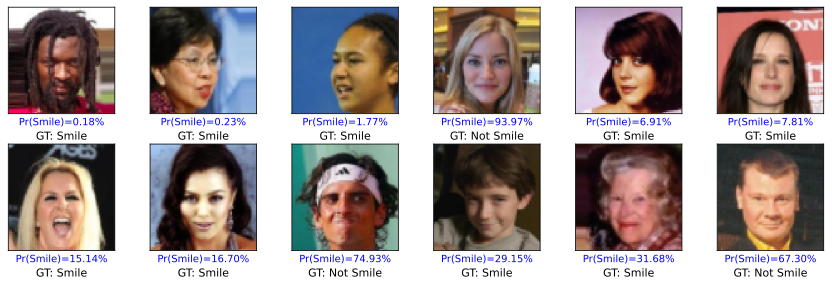

In [31]:
class_names = {
    0: 'Not Smile',
    1: 'Smile'
}

confused = (pred_table
    .sort_values('confidence', ascending=False)
    .query('correct == False')
)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    img_index = confused.index[i]
    image = X[img_index]
    row = confused.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image.permute(1, 2, 0).cpu().detach(), cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['truth']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where model is confidently wrong. Note that these are examples where the model has the highest cross-entropy loss. Here we have to look out for incorrect labels. Otherwise, this may be fixed by preprocessing or adding further augmentation (e.g. adjust brightness) or getting more data. Images with ambiguous labels should have low prediction confidence. See next figure.

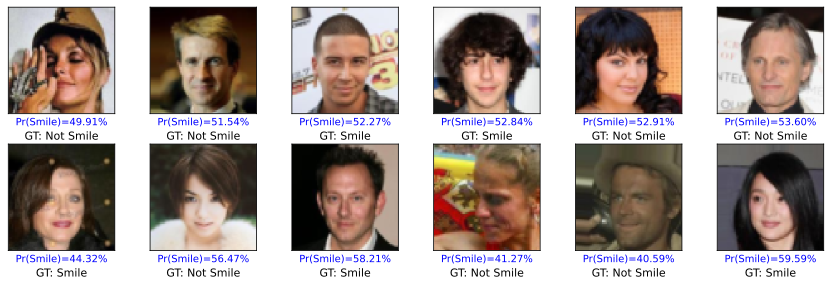

In [32]:
unsure = pred_table.sort_values('confidence', ascending=True)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_index = unsure.index[i]
    image = X[image_index].permute(1, 2, 0)
    row = unsure.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image.detach().cpu(), cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['truth']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where model have low confidence. Indeed, for some of these faces have ambiguous smiles. We can see that the model is having trouble with smiles that do not show teeth which makes sense.

## Appendix: Class activation maps (CAM)

Recall that our model used a GAP layer followed by one fully-connected layer:

In [33]:
trainer.model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flat

```{figure} ../../img/cams.png
---
width: 50em
---
{cite}`cams` GAP layer flattens the final feature map by collapsing its spatial dimensions. Here the first kernel detects something around the seatbelt or chest area. This however turns out to be irrelevant (i.e. $\boldsymbol{\mathsf{w}}_1 \approx 0$) for the Australian terrier class as can be seen in the final heatmap.
```

The last layer in a GAP-CNN is a linear combination of the average pixel values of the last feature map. 
Our network has 256 output channels in the last kernel which is interpreted as precisely features that the network detects to determine the class of the image. Since spatial orientation is preserved up to the final layer, the activations of the last kernel can be projected to the input into a sort of heatmap. The resulting map is called the **class activation map** (CAMs) {cite}`cams`. To construct the CAM for class $j$, we use the learned weights ${\boldsymbol{\mathsf w}}_{ij}$ on the final feature map $f_k(\boldsymbol{\mathsf x})$ of shape (8, 8) for $k = 1, \ldots, 256$:

$$\textsf{CAM}(\boldsymbol{\mathsf x}, j) = \sum_{k=1}^{256} f_k(\boldsymbol{\mathsf x})\,{\boldsymbol{\mathsf w}}_{kj}.$$

The resulting 8×8 image is resized to the same height and width the input image $\boldsymbol{\mathsf x}$.

In [34]:
from functools import reduce

@torch.no_grad()
def compute_cam(x, t):
    """CAM of one instance taken with respect to the predicted label.
    Note that this function has no access to the ground truth label."""
    
    class_weight = trainer.model[-1].weight         # (m, 256) where m = 2 (binary)
    x = torch.tensor(x).to(device)
    with trainer.eval_context():
        detectors = list(trainer.model.modules())[1:][:-3]
        act_map = reduce(lambda x, f: f(x), detectors, x)
    
    weights = class_weight[t]                       # (B, 256)
    cam = act_map * weights.view(-1, 256, 1, 1)     # (B, 256, 8, 8) * (B, 256, 1, 1)
    cam = cam.sum(dim=1, keepdim=True)              # (B, 1, 8, 8)
    
    return cam

Plotting constructed CAMs for test examples:

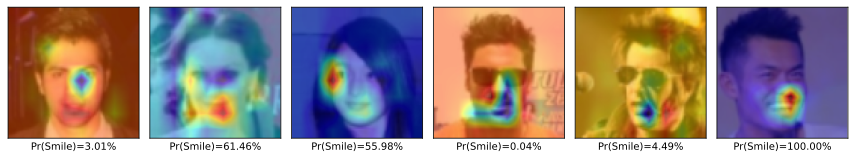

In [35]:
@torch.no_grad()
def plot_cam(x, t, height=96, width=96, threshold=0.0):
    """Plot class activation maps (CAM) wrt. predicted label for each image in batch."""

    class_label = {0: 'Not Smile', 1: 'Smile'}
    resize = transforms.Resize(size=(height, width))

    x = x.to(device)
    img = resize(x)
    cam = compute_cam(x, t)

    t = [t] * len(x)
    with trainer.eval_context():
        probs = F.softmax(trainer.model(x), dim=1)
    
    fig, ax = plt.subplots(1, 6, figsize=(12, 4))
    for b in range(6):
        heatmap = cam[b].detach().cpu()
        heatmap = resize(heatmap).permute(1, 2, 0)
        heatmap = heatmap.detach().cpu()
        ax[b].imshow(img[b].permute(1, 2, 0).detach().cpu())
        ax[b].imshow(heatmap, alpha=0.70, cmap='jet', interpolation='sinc')
        ax[b].set_xlabel(f"Pr({class_label[t[b]]})={probs[b][t[b]].item()*100:.2f}%", color='black')
        ax[b].set_xticks([])
        ax[b].set_yticks([])

    fig.tight_layout()


plot_cam(X[6:12], t=1, threshold=0.30) # smile activation

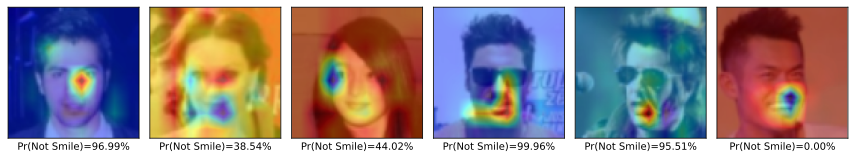

In [36]:
plot_cam(X[6:12], t=0, threshold=0.30)

**Figure.** CAMs of test images for the smile (top) and not smile class (bottom). Red indicates high class activation. Notice that examples predicted with high confidence have high class activations in the mouth area for either class. This makes sense since both smile and not smile can be determined by looking at the mouth region. 

But we expect these to be distinct feature maps in the last convolution. This is a nice interpretability property of our CNN-GAP-FC network where the last CNN layer is forced to learn abstract features for smile and not smile classes. Smile detectors are determined by having positive weights for the positive class after training (and are expected to have negative weights for the negative class), and vice-versa. Indeed:

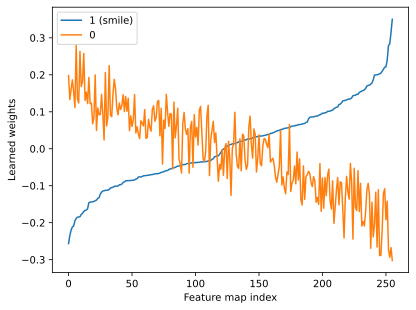

In [37]:
class_weight = trainer.model[-1].weight
h = class_weight[1].argsort()
with torch.no_grad():
    plt.plot(class_weight[1][h].cpu(), label='1 (smile)')
    plt.plot(class_weight[0][h].cpu(), label='0')
    plt.legend()
    plt.xlabel('Feature map index')
    plt.ylabel('Learned weights')

---
■